# Data exploration and basic analysis

For this we will be doing some testing of different modelling techniques and seeing whether anything works.

## Data importing

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

In [2]:
climate = pd.read_csv('clean data/climate_factors.csv', index_col='Unnamed: 0')
socio = pd.read_csv('clean data/socioec_factors.csv', index_col='Unnamed: 0')
wstress = pd.read_csv('clean data/water_stress.csv')
countries = pd.read_csv('shared_country_codes.csv')
countries = list(countries['0'])

## Checking the clean data

Need to remove the unnecessary countries from the datasets using the shared countries information. And then see what the situation is with the NANs.

In [3]:
climate = climate[climate['Country'].isin(countries)]
climate.isnull().sum().reset_index().rename(columns={'index':'Variables',0:'# NaN'})

,Variables,# NaN
0,Country,0
1,Temp,0
2,Rain,0
3,IRWR,0
4,ERWR,0
5,TRWR,0
6,Dep_ratio,4


Checking which countries are those that have NANs in the columns that have few NANs.

In [4]:
#climate = climate.drop(climate.columns[[6]], axis = 1)
climate[climate.isna().any(axis = 1)]

,Country,Temp,Rain,IRWR,ERWR,TRWR,Dep_ratio
92,KGZ,0.000000,0.000000,0.0,0.0,0.0,NaN
172,SYC,27.674428,1648.542325,0.0,0.0,0.0,NaN
177,TJK,0.000000,0.000000,0.0,0.0,0.0,NaN
184,TUR,0.000000,0.000000,0.0,0.0,0.0,NaN


In [5]:
socio = socio[socio['Country'].isin(countries)]
socio.isnull().sum().reset_index().rename(columns={'index':'Variables',0:'# NaN'})

,Variables,# NaN
0,Country,0
1,rural_pop,0
2,urban_pop,0
3,HDI,0
4,r_u,0
5,r_u_access,0
6,pop_growth,0
7,mort_rate,0
8,GDP_pcp,3
9,life_ex,0


Checking the NAs in the socio economic data

In [6]:
socio[socio.isna().any(axis = 1)]

,Country,rural_pop,urban_pop,HDI,r_u,r_u_access,pop_growth,mort_rate,GDP_pcp,life_ex
121,SYR,8495.489,9774.379,0.544,0.869159,0.944745,-3.60,17.8,NaN,70.2
135,VEN,3778.814,28198.251,0.735,0.134009,0.820000,0.02,17.6,NaN,72.6
138,YEM,18075.808,10174.612,0.463,1.776560,0.645833,2.58,43.0,NaN,66.0


Checking which countries are those that have NANs in the columns that have few NANs.

In [7]:
wstress = wstress[wstress['Country'].isin(countries)]
wstress.isnull().sum()

wstress[wstress.isna().any(axis=1)]

,Country,WS_MDG,WUE_SDG,WS_SDG
43,DJI,6.333333,NaN,6.333333
64,GNQ,0.076154,NaN,0.183503
66,GRD,7.050000,NaN,7.050000
104,MDV,15.666667,NaN,15.666667
130,PNG,0.048951,NaN,0.132243
156,SYC,NaN,89.323035,NaN


## Exploring the data

First need to merge the explanatory datasets (climate and socio economic) with the target dataset.


In [8]:
allclimate = pd.merge(climate, wstress, on = 'Country', how = 'outer')
#allclimate = allclimate.drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y'])
allclimate = allclimate.drop(allclimate[allclimate['Country'] == 'SYC'].index)
allclimate.isna().sum()

Country      0
Temp         0
Rain         0
IRWR         0
ERWR         0
TRWR         0
Dep_ratio    3
WS_MDG       0
WUE_SDG      5
WS_SDG       0
dtype: int64

In [9]:
cols = list(allclimate.columns)
#cols.remove('Country')
cols

['Country',
 'Temp',
 'Rain',
 'IRWR',
 'ERWR',
 'TRWR',
 'Dep_ratio',
 'WS_MDG',
 'WUE_SDG',
 'WS_SDG']

In [10]:
allsocio = pd.merge(socio, wstress, on = 'Country', how = 'outer')
allsocio = allsocio.drop(allsocio[allsocio['Country'] == 'SYC'].index)
allsocio.isna().sum()

Country       0
rural_pop     0
urban_pop     0
HDI           0
r_u           0
r_u_access    0
pop_growth    0
mort_rate     0
GDP_pcp       3
life_ex       0
WS_MDG        0
WUE_SDG       5
WS_SDG        0
dtype: int64

## Exploratory plots

We can plot the explanatory variables against the potential target variables. 

### Climate data plots

In [11]:
cols = list(allclimate.columns)
#cols.remove('Country')
climate_exp_cols = cols
climate_exp_cols.remove('WS_MDG')
climate_exp_cols.remove('WUE_SDG')
climate_exp_cols.remove('WS_SDG')
climate_exp_cols.remove('Country')

climate_expl_choice = widgets.Dropdown(
    options=climate_exp_cols,
    value=climate_exp_cols[0],
    description='Value:',
    disabled=False,
)

trgt_cols = ['WS_MDG', 'WUE_SDG', 'WS_SDG']

climate_trgt_choice = widgets.Dropdown(
    options = trgt_cols,
    value = trgt_cols[0],
    description = 'Value:',
    disabled = False,
)

climate_log_choice = widgets.Dropdown(
    options = ['None', 'Target', 'Explanatory', 'Both'],
    value = 'None',
    description = 'Selection:',
    disabled = False
)

selection = widgets.Accordion(children=[climate_expl_choice, climate_trgt_choice, climate_log_choice])
selection.set_title(0, 'Explanatory variable')
selection.set_title(1, 'Target variable')
selection.set_title(2, 'Take log of variables')
selection

Accordion(children=(Dropdown(description='Value:', options=('Temp', 'Rain', 'IRWR', 'ERWR', 'TRWR', 'Dep_ratio…

Text(0.5, 1.0, 'Climate data exploratory plot')

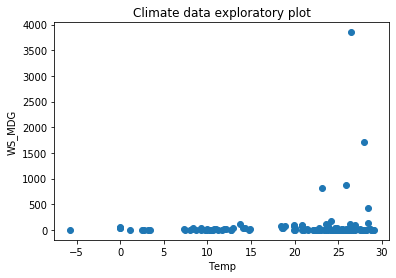

In [12]:
if climate_log_choice.value == 'None':
    plt.scatter(x = allclimate[climate_expl_choice.value], y = (allclimate[climate_trgt_choice.value]))
elif climate_log_choice.value == 'Target':
    plt.scatter(x = allclimate[climate_expl_choice.value], y = np.log(allclimate[climate_trgt_choice.value]))
elif climate_log_choice.value == 'Explanatory':
    plt.scatter(x = np.log(allclimate[climate_expl_choice.value]), y = (allclimate[climate_trgt_choice.value]))
elif climate_log_choice.value == 'Both':
    plt.scatter(x = np.log(allclimate[climate_expl_choice.value]), y = np.log(allclimate[climate_trgt_choice.value]))
plt.xlabel(climate_expl_choice.value)
plt.ylabel(climate_trgt_choice.value)
plt.title('Climate data exploratory plot')

If we play around with the plots we can see that the target variables have a distribution with many small values and a few very large values. If we take the *log()* of the target values the plots look a lot better and much more readable. This is something that we should keep in mind when creating model, especially regression models.

All the water resource explanatory variables suffer from a similar problem of having varied values with many small values and a few very large values.

### Socio economic data plots

In [13]:
cols = list(allsocio.columns)
socio_exp_cols = cols
socio_exp_cols.remove('WS_MDG')
socio_exp_cols.remove('WUE_SDG')
socio_exp_cols.remove('WS_SDG')
socio_exp_cols.remove('Country')

socio_expl_choice = widgets.Dropdown(
    options=socio_exp_cols,
    value=socio_exp_cols[0],
    description='Value:',
    disabled=False,
)

socio_trgt_choice = widgets.Dropdown(
    options = trgt_cols,
    value = trgt_cols[0],
    description = 'Value:',
    disabled = False,
)

socio_log_choice = widgets.Dropdown(
    options = ['None', 'Target', 'Explanatory', 'Both'],
    value = 'None',
    description = 'Selection:',
    disabled = False
)

socio_selection = widgets.Accordion(children=[socio_expl_choice, socio_trgt_choice, socio_log_choice])
socio_selection.set_title(0, 'Explanatory variable')
socio_selection.set_title(1, 'Target variable')
socio_selection.set_title(2, 'Take log of variables')
socio_selection

Accordion(children=(Dropdown(description='Value:', options=('rural_pop', 'urban_pop', 'HDI', 'r_u', 'r_u_acces…

Text(0.5, 1.0, 'Socio economic data exploratory plot')

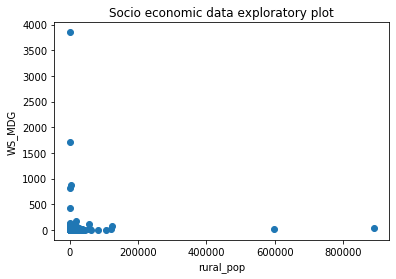

In [14]:
if socio_log_choice.value == 'None':
    plt.scatter(x = allsocio[socio_expl_choice.value], y = (allsocio[socio_trgt_choice.value]))
elif socio_log_choice.value == 'Target':
    plt.scatter(x = allsocio[socio_expl_choice.value], y = np.log(allsocio[socio_trgt_choice.value]))
elif socio_log_choice.value == 'Explanatory':
    plt.scatter(x = np.log(allsocio[socio_expl_choice.value]), y = (allsocio[socio_trgt_choice.value]))
elif socio_log_choice.value == 'Both':
    plt.scatter(x = np.log(allsocio[socio_expl_choice.value]), y = np.log(allsocio[socio_trgt_choice.value]))
plt.xlabel(socio_expl_choice.value)
plt.ylabel(socio_trgt_choice.value)
plt.title('Socio economic data exploratory plot')

## Basic modelling

We will use some basic modelling techniques to whether there are any interesting behaviours in the data. Based on the exploratory plots, it would make sense to use the *log()* values for some of the variables, both explanatory and target, for some types of the modelling techniques.

### Compare clusters

Create the same number of clusters for the climate and socio economic data. See what countries are in the same clusters in both.

Need to perform some preprocessing first:
- Normalise the variables to N(0,1) using StandardScaler

In [15]:
noclusters = widgets.IntSlider(
    value=3,
    min=2,
    max=7,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

noclusters

IntSlider(value=3, continuous_update=False, description='Test:', max=7, min=2)

Choose the number of clusters to create.

In [16]:
impute = KNNImputer()
normalise = StandardScaler()
kmeans = KMeans(n_clusters=noclusters.value, init='k-means++', max_iter=1000)
spectral = SpectralClustering(n_clusters=noclusters.value, assign_labels='discretize', random_state=0)

kmeans_pipe = Pipeline([('norm', normalise), ('cluster', kmeans)])
cluster_pipe = Pipeline([('norm', normalise), ('cluster', spectral)])

kmeans_pipe.fit(allclimate.drop(allclimate.columns[[0, 7, 8, 9]], axis = 1))
kmeans_pred = kmeans_pipe.fit_predict(allclimate.drop(allclimate.columns[[0, 7, 8, 9]], axis = 1))
cluster_pipe.fit(allclimate.drop(allclimate.columns[[0, 7, 8, 9]], axis = 1))
spectral_pred = cluster_pipe.fit_predict(allclimate.drop(allclimate.columns[[0, 7, 8, 9]], axis = 1))

countries = list(allclimate['Country'])

kmeans_climate_clusters = list(zip(countries, kmeans_pred))
spectral_climate_clusters = list(zip(countries, spectral_pred))

kmeans_pipe = Pipeline([('impute', impute), ('norm', normalise), ('cluster', kmeans)])
spectral_pipe = Pipeline([('impute', impute), ('norm', normalise), ('cluster', spectral)])

kmeans_pipe.fit_transform(allsocio.drop(allsocio.columns[[0, 10, 11, 12]], axis = 1))
spectral_pipe.fit(allsocio.drop(allsocio.columns[[0, 10, 11, 12]], axis = 1))
kmeans_pred = kmeans_pipe.fit_predict(allsocio.drop(allsocio.columns[[0, 10, 11, 12]], axis = 1))
spectral_pred = spectral_pipe.fit_predict(allsocio.drop(allsocio.columns[[0, 10, 11, 12]], axis = 1))

countries = list(allsocio['Country'])

kmeans_socio_clusters = list(zip(countries, kmeans_pred))
spectral_socio_clusters = list(zip(countries, spectral_pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Now check which countries are in the together in the same clusters for the climate and socio economic factors.

In [17]:
km_climate_sets = []
km_socio_sets = []
for i in range(int(noclusters.value)):
    kmeans_climate_clusters = np.asarray(kmeans_climate_clusters)
    km_c = kmeans_climate_clusters[kmeans_climate_clusters[:, 1].astype(int) == i, 0]
    kmeans_socio_clusters = np.asarray(kmeans_socio_clusters)
    km_s = kmeans_socio_clusters[kmeans_socio_clusters[:, 1].astype(int) == i, 0]
    km_climate_sets.append(km_c)
    km_socio_sets.append(km_s)

NameError: name 'kmeans_climate_clusters' is not defined

Check which sets of countries are together in a cluster for both the climate and socio economic data.

In [47]:
common = []
for i in range(len(km_socio_sets)):
    for j in range(len(km_climate_sets)):
        temp = set.intersection(set(km_socio_sets[i]),set(km_climate_sets[j]))
        if len(temp) > 1:
            common.append(temp)

common

[{'BEL',
  'CHL',
  'DEU',
  'DNK',
  'ESP',
  'FIN',
  'FRA',
  'GBR',
  'GRC',
  'IRL',
  'ISL',
  'KOR',
  'LTU',
  'NOR',
  'NZL',
  'SVN',
  'SWE'},
 {'CAN', 'USA'},
 {'ARE',
  'AUS',
  'BHR',
  'CYP',
  'HUN',
  'ISR',
  'KWT',
  'LUX',
  'MLT',
  'NLD',
  'OMN',
  'QAT',
  'SAU'},
 {'AGO',
  'BFA',
  'CAF',
  'CIV',
  'CMR',
  'COD',
  'COG',
  'GAB',
  'GIN',
  'GNQ',
  'HTI',
  'MDG',
  'SLE',
  'TGO',
  'TZA'},
 {'AFG',
  'BEN',
  'DJI',
  'GHA',
  'GMB',
  'MLI',
  'MOZ',
  'MRT',
  'PAK',
  'SEN',
  'TCD',
  'YEM',
  'ZMB'},
 {'BGD',
  'BLZ',
  'BRB',
  'CRI',
  'DOM',
  'ECU',
  'FJI',
  'GRD',
  'GTM',
  'HND',
  'JAM',
  'LKA',
  'MDV',
  'MYS',
  'NIC',
  'PAN',
  'PHL',
  'SLV',
  'STP',
  'THA',
  'TTO',
  'VEN',
  'VNM'},
 {'ALB', 'ARM', 'BGR', 'KGZ', 'LVA', 'MNG', 'TUR'},
 {'COL', 'IDN', 'PER'},
 {'ARG',
  'AZE',
  'BOL',
  'BWA',
  'CPV',
  'DZA',
  'EGY',
  'IRN',
  'IRQ',
  'JOR',
  'LBY',
  'MAR',
  'MDA',
  'MEX',
  'NAM',
  'PRY',
  'ROU',
  'SYR',
  'TUN',
  

We can see some interesting resultswhen we set the number of clusters to 5. 

For example the following countries are together in the same clusters for both climate and soico economimc data:
- Colombia, Indonesia and Peru.
- Nepal and Tajikistan.
- Albania, Armenia, Bulgaria, Kyrzygstan, Latvia, Mongolia, and Turkey.

# Data modelling


Doing data analysis using the compiled final data. Using similar solutions as Andreas.


In [13]:
df_final = pd.read_csv('clean data/final_data.csv', index_col = 0)

df_raw_target = df_final.iloc[:, 1:4]
df_raw_pred = df_final.iloc[:, 4:]

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, accuracy_score
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import classification_report,  confusion_matrix
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

In [18]:
def log_transform(x):
    return np.log(x + 1)

logscaler = FunctionTransformer(log_transform)
pca_target = PCA(n_components = 2)

pipe_target = Pipeline([('scaler', logscaler), ('reduce_dim', pca_target)])

In [19]:
df_target = pipe_target.fit_transform(df_raw_target)

# Example of functionality of app

App will have selection of the adjustemnt of the climate and socio economic variables. Based on the selected settings, the value of the selected water stress indicator will be plotted for a certain time window.

In [90]:
target_cols = ['Water stress', 'Water use efficiency']
socio_cols = list(df_final.iloc[:, 10:].columns)
climate_cols = list(df_final.iloc[:, 4:10].columns)
countries = list(df_final.iloc[:, 0])

target_choice = widgets.Dropdown(
    options = target_cols,
    value = target_cols[0],
    description = 'Target selection:',
    disabled = False
)


country_choice = widgets.Dropdown(
    options = countries,
    value = countries[0],
    description = 'Country selection:',
    disabled = False
)

urban_shift = widgets.FloatSlider(
    value=0,
    min=-5,
    max=5.0,
    step=0.1,
    description='Rural to urban population shift:',
    disabled=False
)

pop_growth = widgets.FloatSlider(
    value=0,
    min=-5,
    max=5.0,
    step=0.1,
    description='Yearly population growth:',
    disabled=False
)

mortality_rate = widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='Yearly change in mortality rate:',
    disabled=False
)


gdp_change = widgets.FloatSlider(
    value=0,
    min=-10,
    max=10.0,
    step=0.5,
    description='Average yearly GDP growth:',
    disabled=False
)


selection = widgets.Accordion(children=[target_choice, country_choice, urban_shift, pop_growth, gdp_change])
selection.set_title(0, 'Target variable')
selection.set_title(1, 'Country choice')
selection.set_title(2, 'Socio economic change')
selection.set_title(3, 'Population change')
selection.set_title(4, 'Average GDP growth')

### How it would work

First user selects the target variable and the country of interest.

Then they can select how the explanatory varaibles will change on a yearly basis on a percentage cahgne basis using the sliders.

Potentially, select for how many years these predicitons have to be created for.

In [91]:
selection

Accordion(children=(Dropdown(description='Target selection:', options=('Water stress', 'Water use efficiency')…

In the app these selection slider should look better then they do here.

Using the selected value the future values are predicted.

In [92]:
changes = [0, 0, 0, 0, 0, 0, -urban_shift.value, urban_shift.value, 0, 0, 0, pop_growth.value, mortality_rate.value, gdp_change.value, 0]
changes = np.asarray(changes)*0.01 + 1
changes

array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.981, 1.019, 1.   ,
       1.   , 1.   , 0.989, 1.   , 1.025, 1.   ])

We can then create a matrix with the changes in values for the time period in which we want to predict the water scarcity.

In [99]:
mx_change = np.zeros((5, 15))

for i in range(5):
    mx_change[i] = changes**i
    
mx_change

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.981     , 1.019     , 1.        , 1.        ,
        1.        , 0.989     , 1.        , 1.025     , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.962361  , 1.038361  , 1.        , 1.        ,
        1.        , 0.978121  , 1.        , 1.050625  , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.94407614, 1.05808986, 1.        , 1.        ,
        1.        , 0.96736167, 1.        , 1.07689062, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.92613869, 1.07819357, 1.        , 1.        ,
        1.        , 0.95672069, 1.        , 

And then multipy the current values by the selected changes.

In [108]:
current = np.asarray(df_final.loc[df_final['Country'] == country_choice.value])[:, 4:]
future = current * mx_change
future

array([[14.074741986301367, 349.73694499999993, 47.15, 18.18, 65.33,
        0.2782795040563294, 26558.609, 8971.472, 0.493,
        2.9603401760602943, 0.6010230179028133, 3.06, 53.2, 2226.0, 63.4],
       [14.074741986301367, 349.73694499999993, 47.15, 18.18, 65.33,
        0.2782795040563294, 26053.995429, 9141.929967999999, 0.493,
        2.9603401760602943, 0.6010230179028133, 3.02634, 53.2,
        2281.6499999999996, 63.4],
       [14.074741986301367, 349.73694499999993, 47.15, 18.18, 65.33,
        0.2782795040563294, 25558.969515849, 9315.626637391999, 0.493,
        2.9603401760602943, 0.6010230179028133, 2.99305026, 53.2,
        2338.69125, 63.4],
       [14.074741986301367, 349.73694499999993, 47.15, 18.18, 65.33,
        0.2782795040563294, 25073.349095047866, 9492.623543502445, 0.493,
        2.9603401760602943, 0.6010230179028133, 2.96012670714, 53.2,
        2397.158531249999, 63.4],
       [14.074741986301367, 349.73694499999993, 47.15, 18.18, 65.33,
        0.2782795

These future values can now be used as inputs for the prediciton model. The predicitons can then be plotted against the years.